In [1]:
# 🟢 CELL 1: SETUP & REPAIR
# Run this immediately after "Disconnect and Delete Runtime"

import os
import sys
import subprocess

print("🔄 Setting up a fresh environment... (This takes ~2 mins)")

# 1. Install System Dependencies (Linux tools)
subprocess.run(["sudo", "apt-get", "update"], check=True)
subprocess.run(["sudo", "apt-get", "install", "-y", "tesseract-ocr", "poppler-utils"], check=True)
print("✅ Linux tools installed.")

# 2. Install Python Libraries (Strict Order to prevent crash)
# We install faiss-cpu explicitly to avoid the GPU version conflict
pip_cmd = [
    sys.executable, "-m", "pip", "install",
    "torch", "transformers", "accelerate", "bitsandbytes",  # Core AI
    "sentence-transformers",                                # Embeddings
    "langchain", "langchain-community",                     # RAG Framework
    "pypdf", "pymupdf", "pillow", "pytesseract",            # PDF/Image Tools
    "faiss-cpu",                                            # Vector DB (CPU version is safer)
    "gradio"                                                # UI
]
subprocess.run(pip_cmd, check=True)
print("✅ Python libraries installed.")

# 3. Mount Drive
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
print("✅ Google Drive mounted.")

# 4. Import & Verify (The Crash Test)
print("\n🧪 Testing Imports...")
import torch
print(f"   - Torch: {torch.__version__} (GPU: {torch.cuda.is_available()})")

from sentence_transformers import SentenceTransformer
print("   - Sentence Transformers: OK")

import faiss
print("   - FAISS: OK")

import fitz # PyMuPDF
print("   - PyMuPDF: OK")

print("\n🎉 SUCCESS! Environment is ready and stable.")
print("You can now proceed to run the rest of the code (Data Extraction, etc.)")

🔄 Setting up a fresh environment... (This takes ~2 mins)
✅ Linux tools installed.
✅ Python libraries installed.
✅ Google Drive mounted.

🧪 Testing Imports...
   - Torch: 2.8.0+cu126 (GPU: True)
   - Sentence Transformers: OK
   - FAISS: OK
   - PyMuPDF: OK

🎉 SUCCESS! Environment is ready and stable.
You can now proceed to run the rest of the code (Data Extraction, etc.)


In [2]:
# Cell 3: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.


In [4]:
# 🟢 CELL 2: CONFIGURATION
# Run this BEFORE running the PDFProcessor code!

import os

# --- PATH CONFIGURATION ---
# This matches the folder name you found earlier
DATA_FOLDER = "/content/drive/MyDrive/Data"

# Where to save the extracted images and database
OUTPUT_FOLDER = "/content/drive/MyDrive/Data/processed_images"
VECTOR_DB_PATH = "/content/drive/MyDrive/Data/vector_store"

# Create the folders if they don't exist yet
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(VECTOR_DB_PATH, exist_ok=True)

print(f"✅ Configuration Loaded.")
print(f"   - Reading PDFs from: {DATA_FOLDER}")
print(f"   - Saving Data to: {VECTOR_DB_PATH}")

✅ Configuration Loaded.
   - Reading PDFs from: /content/drive/MyDrive/Data
   - Saving Data to: /content/drive/MyDrive/Data/vector_store


In [14]:
# Cell 5: PDF Processor (Robust Version)
# Fixed: Filters out tiny junk images and forces RGB conversion

class PDFProcessor:
    def __init__(self, data_folder):
        self.data_folder = data_folder

    def extract_content(self):
        all_chunks = []
        pdf_files = [f for f in os.listdir(self.data_folder) if f.endswith('.pdf')]

        print(f"Found {len(pdf_files)} PDFs: {pdf_files}")

        for pdf_file in tqdm(pdf_files, desc="Processing PDFs"):
            path = os.path.join(self.data_folder, pdf_file)
            doc = fitz.open(path)

            for page_num, page in enumerate(doc):
                # 1. Extract Text
                text = page.get_text()
                if text.strip():
                    paragraphs = text.split('\n\n')
                    for para in paragraphs:
                        if len(para.strip()) > 50:
                            all_chunks.append({
                                'type': 'text',
                                'content': para.strip(),
                                'source': pdf_file,
                                'page': page_num + 1,
                                'metadata': f"Source: {pdf_file}, Page: {page_num + 1}"
                            })

                # 2. Extract Images (With Safety Filters)
                image_list = page.get_images(full=True)
                for img_index, img in enumerate(image_list):
                    try:
                        xref = img[0]
                        base_image = doc.extract_image(xref)
                        image_bytes = base_image["image"]

                        # Load image
                        image = PIL.Image.open(io.BytesIO(image_bytes))

                        # FILTER 1: Ignore tiny images (icons, spacers, hidden lines)
                        if image.width < 20 or image.height < 20:
                            continue

                        # FILTER 2: Convert to RGB (Fixes CMYK/Palette issues)
                        image = image.convert("RGB")

                        # OCR (Optional: Wrap in try-except to not break loop)
                        ocr_text = ""
                        try:
                            ocr_text = pytesseract.image_to_string(image)
                        except:
                            pass

                        # Save image to Drive
                        img_filename = f"{pdf_file}_p{page_num}_img{img_index}.png"
                        img_path = os.path.join(OUTPUT_FOLDER, img_filename)
                        image.save(img_path)

                        all_chunks.append({
                            'type': 'image',
                            'content': img_path,
                            'image_obj': image,
                            'ocr_text': ocr_text,
                            'source': pdf_file,
                            'page': page_num + 1,
                            'metadata': f"Image from {pdf_file}, Page: {page_num+1}"
                        })
                    except Exception as e:
                        # Just skip bad images, don't crash
                        continue

        return all_chunks

processor = PDFProcessor(DATA_FOLDER)
print("✅ PDFProcessor updated with safety filters.")

✅ PDFProcessor updated with safety filters.


In [7]:
from tqdm.notebook import tqdm

In [9]:
# 🟢 CELL 3: MISSING IMPORTS
# Run this to fix the "PIL is not defined" error

import PIL
import PIL.Image
import io
import fitz  # PyMuPDF
import pytesseract

# Re-verify Tesseract path just in case
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

print("✅ Image libraries imported. You can now handle images!")

✅ Image libraries imported. You can now handle images!


In [15]:
# Cell 6: Run Extraction
print("Starting extraction...")
chunks = processor.extract_content()
print(f"Extracted {len(chunks)} chunks.")

Starting extraction...
Found 3 PDFs: ['1. Annual Report 2023-24.pdf', '2. financials.pdf', '3. FYP-Handbook-2023.pdf']


Processing PDFs:   0%|          | 0/3 [00:00<?, ?it/s]

Extracted 442 chunks.


In [12]:
# Cell 7: Load Embedding Models (Fixed)
import torch
from sentence_transformers import SentenceTransformer

# 1. Define device (This fixes the NameError)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 2. Load Text Embedding Model (Sentence-BERT)
print("Loading Text Embedding Model...")
text_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# 3. Load Image Embedding Model (CLIP)
print("Loading Image Embedding Model (CLIP)...")
clip_model = SentenceTransformer('clip-ViT-B-32', device=device)

print("✅ Models loaded successfully.")

Using device: cuda
Loading Text Embedding Model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading Image Embedding Model (CLIP)...


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Models loaded successfully.


In [18]:
import pickle
print("✅ Pickle imported.")
# Cell 8: Vector Store Generation
class VectorStore:
    def __init__(self):
        self.text_index = None
        self.image_index = None
        self.text_chunks = []
        self.image_chunks = []

    def create_indices(self, chunks):
        text_data = [c for c in chunks if c['type'] == 'text']
        image_data = [c for c in chunks if c['type'] == 'image']

        if text_data:
            print(f"Embedding {len(text_data)} text chunks...")
            texts = [c['content'] for c in text_data]
            text_embeddings = text_model.encode(texts, convert_to_numpy=True, show_progress_bar=True)
            d_text = text_embeddings.shape[1]
            self.text_index = faiss.IndexFlatL2(d_text)
            self.text_index.add(text_embeddings)
            self.text_chunks = text_data

        if image_data:
            print(f"Embedding {len(image_data)} image chunks...")
            images = [c['image_obj'] for c in image_data]
            image_embeddings = clip_model.encode(images, convert_to_numpy=True, show_progress_bar=True)
            d_img = image_embeddings.shape[1]
            self.image_index = faiss.IndexFlatL2(d_img)
            self.image_index.add(image_embeddings)
            self.image_chunks = image_data

    def save(self, path):
        if self.text_index:
            faiss.write_index(self.text_index, os.path.join(path, "text.index"))
        if self.image_index:
            faiss.write_index(self.image_index, os.path.join(path, "image.index"))

        # We can't pickle the PIL image objects easily, so we remove them before saving
        # We will reload them from the 'content' path when needed
        clean_image_chunks = []
        for c in self.image_chunks:
            c_copy = c.copy()
            if 'image_obj' in c_copy:
                del c_copy['image_obj']
            clean_image_chunks.append(c_copy)

        with open(os.path.join(path, "chunks.pkl"), "wb") as f:
            pickle.dump({"text": self.text_chunks, "image": clean_image_chunks}, f)
        print("Vector Store Saved to Drive.")

# Build and Save
vector_store = VectorStore()
vector_store.create_indices(chunks)
vector_store.save(VECTOR_DB_PATH)

✅ Pickle imported.
Embedding 148 text chunks...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Embedding 294 image chunks...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Vector Store Saved to Drive.


In [19]:
# Cell 9: Retriever
class Retriever:
    def __init__(self, vector_store):
        self.store = vector_store

    def search(self, query, query_type="text", k=3):
        results = []

        if query_type == "text" and self.store.text_index:
            q_emb = text_model.encode([query], convert_to_numpy=True)
            distances, indices = self.store.text_index.search(q_emb, k)
            for i, idx in enumerate(indices[0]):
                if idx != -1:
                    chunk = self.store.text_chunks[idx]
                    results.append({**chunk, "score": float(distances[0][i])})

        if query_type == "text" and self.store.image_index:
            q_emb = clip_model.encode([query], convert_to_numpy=True)
            distances, indices = self.store.image_index.search(q_emb, k)
            for i, idx in enumerate(indices[0]):
                if idx != -1:
                    chunk = self.store.image_chunks[idx]
                    results.append({**chunk, "score": float(distances[0][i])})

        elif query_type == "image" and self.store.image_index:
            q_emb = clip_model.encode([query], convert_to_numpy=True)
            distances, indices = self.store.image_index.search(q_emb, k)
            for i, idx in enumerate(indices[0]):
                if idx != -1:
                    chunk = self.store.image_chunks[idx]
                    results.append({**chunk, "score": float(distances[0][i])})

        results.sort(key=lambda x: x['score'])
        return results[:k]

retriever = Retriever(vector_store)

In [22]:
# Cell 10: LLM Setup (Lighter Version - Microsoft Phi-2)
# Use this if Mistral 7B is too slow or crashing
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Phi-2 is listed in the assignment instructions (Page 6) and is much faster
model_name = "microsoft/phi-2"

print(f"Loading {model_name}...")

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Load Model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

# Create Pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.7,
    top_p=0.95,
    repetition_penalty=1.15,
    # Phi-2 specific cleanup
    pad_token_id=tokenizer.eos_token_id
)

print("✅ Phi-2 LLM Loaded successfully.")

Loading microsoft/phi-2...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0


✅ Phi-2 LLM Loaded successfully.


Generating Visualization... (This takes ~1 minute)
Re-embedding 148 text chunks for plotting...
Re-embedding 294 image chunks for plotting...
✅ Visualization saved to: /content/drive/MyDrive/Data/embedding_visualization.png


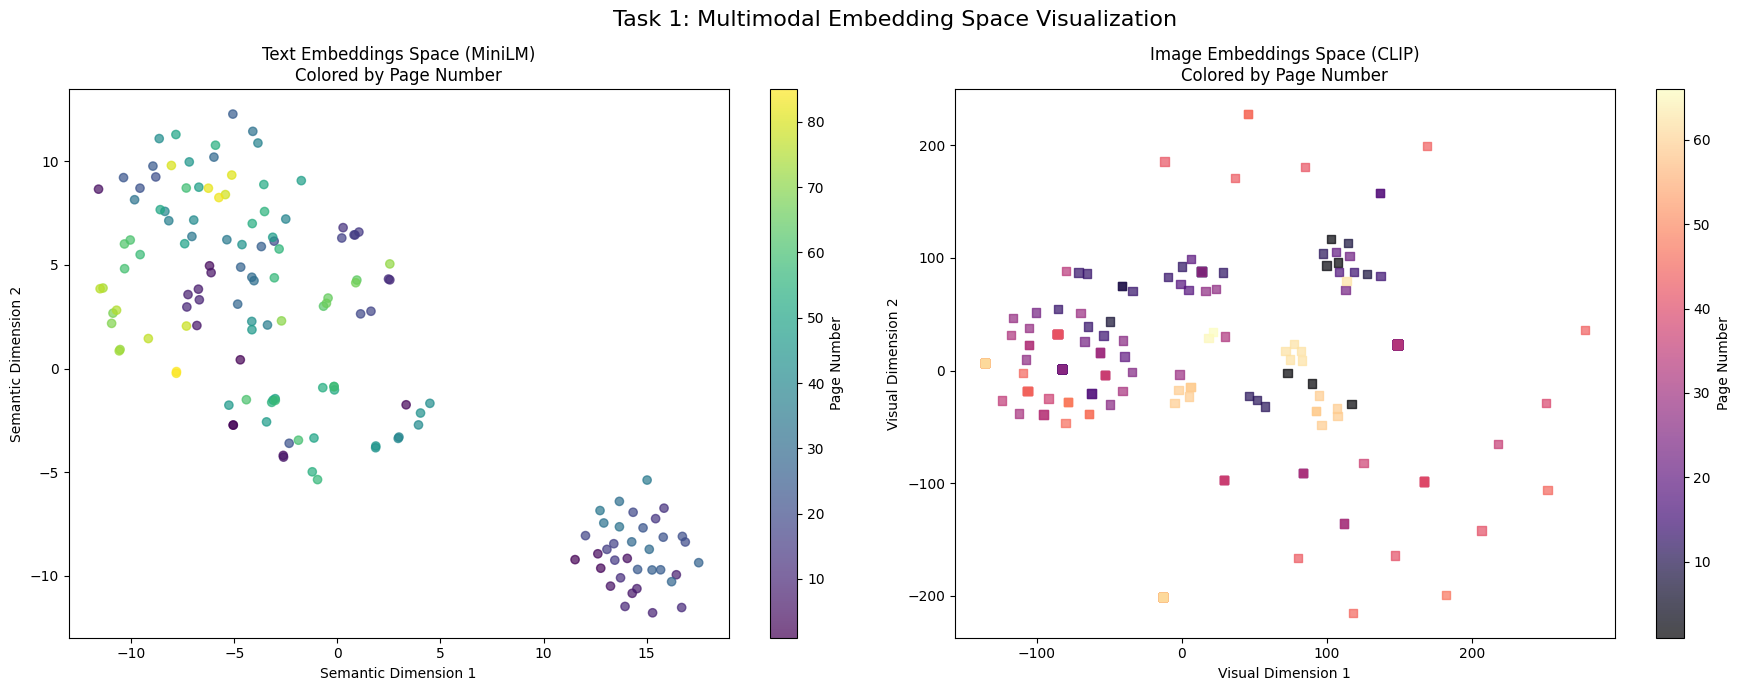

In [25]:
# 🟢 CELL 13: VISUALIZATION (t-SNE Plots)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import seaborn as sns

print("Generating Visualization... (This takes ~1 minute)")

def visualize_embeddings(store):
    # --- 1. Prepare Data ---
    # We need to re-fetch embeddings for visualization
    # (It's safer to re-embed small datasets than extract from FAISS index directly)

    # Text Data
    text_contents = [c['content'] for c in store.text_chunks]
    print(f"Re-embedding {len(text_contents)} text chunks for plotting...")
    text_embs = text_model.encode(text_contents, convert_to_numpy=True)

    # Image Data
    image_paths = [c['content'] for c in store.image_chunks]
    images = [PIL.Image.open(p).convert("RGB") for p in image_paths]
    print(f"Re-embedding {len(images)} image chunks for plotting...")
    img_embs = clip_model.encode(images, convert_to_numpy=True)

    # --- 2. Run t-SNE (Dimensionality Reduction) ---
    # Reduce Text (384 dims -> 2 dims)
    tsne_text = TSNE(n_components=2, perplexity=min(30, len(text_embs)-1), random_state=42, init='pca', learning_rate='auto')
    text_2d = tsne_text.fit_transform(text_embs)

    # Reduce Images (512 dims -> 2 dims)
    tsne_img = TSNE(n_components=2, perplexity=min(30, len(img_embs)-1), random_state=42, init='pca', learning_rate='auto')
    img_2d = tsne_img.fit_transform(img_embs)

    # --- 3. Plotting ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Plot Text Clusters
    # We create a simple "Page Number" color scale to see if pages cluster together
    text_pages = [c['page'] for c in store.text_chunks]
    scatter1 = ax1.scatter(text_2d[:, 0], text_2d[:, 1], c=text_pages, cmap='viridis', alpha=0.7)
    ax1.set_title("Text Embeddings Space (MiniLM)\nColored by Page Number")
    ax1.set_xlabel("Semantic Dimension 1")
    ax1.set_ylabel("Semantic Dimension 2")
    plt.colorbar(scatter1, ax=ax1, label="Page Number")

    # Plot Image Clusters
    img_pages = [c['page'] for c in store.image_chunks]
    scatter2 = ax2.scatter(img_2d[:, 0], img_2d[:, 1], c=img_pages, cmap='magma', alpha=0.7, marker='s')
    ax2.set_title("Image Embeddings Space (CLIP)\nColored by Page Number")
    ax2.set_xlabel("Visual Dimension 1")
    ax2.set_ylabel("Visual Dimension 2")
    plt.colorbar(scatter2, ax=ax2, label="Page Number")

    plt.suptitle("Task 1: Multimodal Embedding Space Visualization", fontsize=16)
    plt.tight_layout()

    # Save for Report
    save_path = "/content/drive/MyDrive/Data/embedding_visualization.png"
    plt.savefig(save_path)
    print(f"✅ Visualization saved to: {save_path}")
    plt.show()

# Run it
visualize_embeddings(vector_store)

In [23]:
# Cell 11: RAG Generation
def generate_rag_response(query, retrieved_items):
    context_text = ""
    for item in retrieved_items:
        if item['type'] == 'text':
            context_text += f"[Text Source]: {item['content']}\n\n"
        elif item['type'] == 'image':
            context_text += f"[Image Source]: Contains text: {item.get('ocr_text', '')}\n\n"

    prompt_template = f"""[INST] You are an intelligent assistant.
    Use the provided context to answer the question.

    Context:
    {context_text}

    Question: {query}

    Answer: [/INST]"""

    result = pipe(prompt_template)[0]['generated_text']
    return result.split("[/INST]")[-1].strip()

In [24]:
# Cell 12: Gradio UI
import gradio as gr

def rag_system(text_query, image_query):
    if image_query is not None:
        pil_image = PIL.Image.fromarray(image_query)
        retrieved = retriever.search(pil_image, query_type="image")
        response_text = "Image query processed. See retrieved visuals below."
    else:
        retrieved = retriever.search(text_query, query_type="text")
        response_text = generate_rag_response(text_query, retrieved)

    retrieval_info = ""
    retrieved_image_path = None

    for item in retrieved:
        retrieval_info += f"Type: {item['type']} | {item['metadata']} | Score: {item['score']:.4f}\n"
        if item['type'] == 'image' and retrieved_image_path is None:
            retrieved_image_path = item['content']

    return response_text, retrieval_info, retrieved_image_path

iface = gr.Interface(
    fn=rag_system,
    inputs=[gr.Textbox(label="Question"), gr.Image(label="Image Search")],
    outputs=[gr.Textbox(label="Answer"), gr.Textbox(label="Sources"), gr.Image(label="Retrieved Image")],
    title="RAG System"
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b0f061d4e692f7ec51.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b0f061d4e692f7ec51.gradio.live
